# La arquitectura BERT (aplicado al análisis de secuencias de proteinas)

La arquitectura __BERT__ (__Bidirectional Encoder Representations from Transformers__) sólo usa el encoder del Transformer, eliminando la pila de decodificación.

El modelo BERT original se lanzó poco después del __Generative Pre-trained Transformer (GPT)__ de OpenAI, y ambos se basaron en el trabajo de la arquitectura Transformer propuesto el año anterior. Mientras que GPT se centró en la generación de lenguaje natural (NLG), BERT priorizó la comprensión del lenguaje natural (NLU). 

<center><img src="images/Transformer_BERT.jpg" width="750px"></center>


## Arquitecturas de sólo codificador (encoder)

El Transformer en 2017 inició una carrera para producir nuevos modelos que se basaran en su diseño innovador. OpenAI en junio de 2018, crea GPT: un modelo de solo decodificador que sobresalió en NLG, y finalmente pasó a impulsar ChatGPT en iteraciones posteriores. Google lanza BERT cuatro meses después: un modelo de solo codificador diseñado para NLU. Ambas arquitecturas pueden producir modelos muy capaces, pero las tareas que pueden realizar son ligeramente diferentes. A continuación se ofrece una descripción general de cada arquitectura.

- __Objetivo__ : hacer predicciones sobre palabras dentro de una secuencia de entrada.
- __Visión general__ : aceptar una secuencia de entrada y crear representaciones vectoriales numéricas enriquecidas para cada token. No tienen el decodificador que generan nuevas palabras como un chatbot, usan pilas de __codificadores o encoders__. Están orientados a reconocimiento de entidades con nombre (__NER__) o análisis de sentimientos. Las representaciones vectoriales enriquecidas creadas por los bloques del codificador son las que le dan a BERT una comprensión profunda del texto de entrada.

__Nota__ : _Es técnicamente posible generar texto con BERT, pero como veremos, esto no es para lo que se pretendía la arquitectura, y los resultados no rivalizan de ninguna manera con los modelos de solo decodificador_

## Arquitecturas de sólo decodificador (decoder)

- __Objetivo__ : Predecir una nueva secuencia de salida en respuesta a una secuencia de entrada.
- __Visión general__ : omitien el bloque de codificador por completo y apilan varios __decodificadores o decoders__ juntos en un solo modelo. Estos modelos aceptan mensajes como entradas y generan respuestas mediante la predicción de la siguiente token, uno a la vez, en una tarea conocida como __Next Token Prediction (NTP)__. 

__Nota__ : _los más conocidos por el público en general debido al uso generalizado de ChatGPT, que funciona con modelos de solo decodificador (GPT-3.5 y GPT-4)_

### En entrenamiento previo

GPT también popularizó el __entrenamiento previo del modelo__. El entrenamiento previo implica __entrenar un modelo grande para adquirir una comprensión amplia del lenguaje__ (que abarca aspectos como el uso de palabras y los patrones gramaticales) con el fin de producir un modelo fundamental independiente de la tarea.

El __ajuste fino__ implica modificar sólo las capas finales que aparecen como __lineales__ (en color morado en el gráfico siguiente), dejando el resto de pesos sin alterar.

Dependiendo de la tarea, el cabezal de clasificación (capa lineal en morado) se puede cambiar para que contenga un número diferente de neuronas de salida. Para una tarea de clasificación multiclase con 10 clases, la cabeza se puede cambiar para que tenga 10 neuronas en la capa de salida.

<center><img src="images/BERT_structure.jpg" width="650px"></center>

### El contexto bidireccional

BERT predice la probabilidad de observar ciertas palabras dado que se han observado palabras anteriores. Esto es algo genérico en todos los modelos de lenguaje. GPT está entrenado para predecir la siguiente palabra más probable en una secuencia. 

La bidireccionalidad es quizás la característica más significativa de BERT, esto es algo que deriva de usar sólo el codificador (que por naturaleza es bidireccional) y descartar el decodificador (que por naturaleza es unidireccional).

__Bidireccional__ denota que cada palabra en la secuencia de entrada puede obtener contexto de las __palabras anteriores y posteriores__ (denominadas __contexto izquierdo y contexto derecho__, respectivamente). En términos técnicos, decimos que el mecanismo de atención puede atender a los tokens anteriores y posteriores de cada palabra.


| Un| hombre | estaba | [MASK] | en | la | orilla | de | un | río |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $\leftarrow$ |  $\leftarrow$ |  $\leftarrow$ |  |  $\rightarrow$ |  $\rightarrow$ |  $\rightarrow$ |  $\rightarrow$ |  $\rightarrow$ |  $\rightarrow$ |

Para BERT, la tarea aquí es predecir la palabra enmascarada indicada por __[MASK]__, dado que esta palabra tiene palabras tanto a la izquierda como a la derecha, las palabras de ambos lados se pueden usar para proporcionar contexto.

Como __modelo bidireccional__, BERT adolece de dos grandes __inconvenientes__:

- Aumento del __tiempo de entrenamiento__.
- __Bajo rendimiento en la generación de idiomas__: es más adecuado para tareas como análisis de sentimientos.


### Pre-entrenamiento de un modelo BERT

El entrenamiento de un modelo bidireccional requiere tareas que permitan usar tanto el contexto izquierdo como el derecho para realizar predicciones. A tal fin diseñaron dos tareas:

- La tarea de __Modelo de Lenguaje Enmascarado (MLM, Masked Language Modeling)__: El modelo debe entrenarse para usar el contexto izquierdo y el contexto derecho de una secuencia de entrada para realizar una predicción. Esto se logra enmascarando aleatoriamente el 15% de las palabras en los datos de entrenamiento y entrenando a BERT para predecir la palabra que falta. Esta tarea ya existía en linguística y se conocía como tarea de __Cloze__ (L. W. Taylor, “Cloze Procedure”: A New Tool for Measuring Readability (1953), Journalism Quarterly, 30(4), 415–433), aunque por la popularidad de BERT se conoce como tarea __MLM__.

<h5 align="center">The cat sat on it because it was a nice rug.</h5> 

<h5 align="center">The cat sat on it [MASK] it was a nice rug.</h5> 


BERT tomará una secuencia de entrada de un máximo de 512 tokens tanto para BERT Base como para BERT Large. Si se encuentran menos del número máximo de tokens en la secuencia, se agregará relleno mediante tokens para alcanzar el recuento máximo de 512.

El número de tokens de salida también será exactamente igual al número de tokens de entrada. Si existe un token enmascarado en la posición $i$ en la secuencia de entrada, la predicción de BERT se encontrará en la posición $i$ en la secuencia de salida.

El error se calcula utilizando una función de pérdida, que suele ser la función de pérdida de entropía cruzada en las posiciones $i$ donde se encuentren los token enmascarados


- La tarea de __Predicción de Siguiente Oración (NSP, Next Sentence Predict)__: el objetivo es clasificar si un segmento (generalmente una oración) sigue lógicamente a otro. Al pre-entrenarse para NSP, BERT es capaz de desarrollar una comprensión del flujo entre oraciones en texto en prosa, una habilidad que es útil para una amplia gama de problemas de NLU, tales como: Pares de oraciones en paráfrasis, Pares hipótesis-premisa en implicación, Pares de preguntas y pasajes en las respuestas a preguntas.

La entrada para NSP consta del primer y segundo segmento (denotados A y B) separados por un token con un segundo token al final. En realidad, BERT espera que al menos un token por secuencia de entrada denote el final de la secuencia, independientemente de si se está realizando NSP o no

Los datos de entrenamiento se pueden generar fácilmente a partir de cualquier corpus monolingüe seleccionando oraciones con su siguiente oración el 50% de las veces y una oración aleatoria para el 50% restante de las oraciones.


### Incrustaciones en un modelo BERT

La __incrustación__ que entra al transformer es suma la __incrustación del token__, más la de __segmento__ (sentencia, frase, palabra) y la __codificación posicional__. 

La incrustación de __token__ es aprendida para cada token, igual que en el modelo Transformer.

La __incrustación por segmento__ se utilizan para distinguir las oraciones dentro de un par de oraciones, como en tareas de clasificación de relaciones entre frases. BERT acepta una secuencia de hasta dos oraciones, A y B. A cada token se le asigna una etiqueta de segmento, usando valores $0$ y $1$:

| [CLS]| La | casa | es | grande | [SEP] | El | perro | duerme | [SEP] |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| $\downarrow$ |  $\downarrow$ |  $\downarrow$ |  $\downarrow$ |  $\downarrow$ |  $\downarrow$ |  $\downarrow$ |  $\downarrow$ |  $\downarrow$ |  $\downarrow$ |
|0| 0 | 0 | 0 | 0 | 0 | 1 | 1 | 1 | 1 |

La __incrustación posicional__ captura la posición del token en la secuencia para permitir que el modelo entienda el orden de las palabras. A diferencia del Transformer, las codificaciones posicionales en BERT son fijas y no son generadas por una función de senos y cosenos. Esto significa que BERT está restringido a 512 tokens en su secuencia de entrada tanto para BERT Base como para BERT Large. Ya se ha comentado que __las secuencias en BERT tienen un máximo de 512 tokens__.



<center><img src="images/embedding_BERT.jpg" width="750px"></center>
  

### Token especiales en BERT

Como se ve en el gráfico anterior BERT tiene algunos token especiales:
- __[PAD]__ : Token de relleno para completar las secuencias hasta 512, cuando son más cortas.
- __[UNK]__ : Token desconocido, cuando no está en el vocabulario.
- __[CLS]__ : Token de clasifiación, se espera al principio de cada secuencia.
- __[SEP]__ : Token separador, separa dos segmentos de una sóla secuencia.
- __[MASK]__ : Token de máscara, se usa para entrenar a BERT.

### Dimensiones usadas en la arquitectura BERT
En el __Transformer original__ las dimensiones son $d_{model}=512$ y el número de cabeceras es $A=8$, quedando  $d_k=512/8=64$.

Mientras que el __BERT base__ $d_{model}=768$ y el número de cabeceras es $A=12$, quedando  $d_k=768/12=64$.

Y el __BERT large__ $d_{model}=1024$ y el número de cabeceras es $A=16$, quedando  $d_k=1024/16=64$.

Ambas versiones de BERT también difieren en algunas características en cuanto número de capas y número de neuronas en las capas de paso adelante

<center><img src="images/BERT_Base_Large.jpg" width="650px"></center>

## Ajuste Fino

El __pre-entrenamiento__ es el primer paso en el marco de trabajo BERT que tiene 2 sub-etapas:

- __Definir el modelo de arquitectura__: número de capas, de cabeceras, dimensiones y otros bloques del modelo.
- __Entrenar el modelo__ en las tareas __MLM__ y __NSP__

El segundo paso es el __ajuste fino__ que se puede descomponer en dos etapas:

- Descargar un modelo elegido con los parámetros BERT __preentrenados__.
- Realizar un ajuste fino de los parámetros para algunas tareas tales como __Recognizing Textual Entailment (RTE)__ y __Situations With Adversarial Generations (SWAG)__

_A continuación se muestras los pasos necesarios para un ajuste fino de un modelo pre-entrenado_

## Se importan librerías

En el presente cuaderno se realiza un proceso de aplicación primero de un módelo BERT para realizar un ajuste fino sobre secuencias de proteinas que se pretenden clasificar y posteriormente se aplica el __modelo T5 para caracterizar, mediante las incrustaciones, familias de proteinas__ que se representan en una gráfica después de realizar una reducción dimensional.

Los modelos parte de la publicación científica:

<a href="https://ieeexplore.ieee.org/abstract/document/9477085">{cite:p}`elnaggar2021prottrans`</a>

Los autores han compartido código en GitHub para saber como manejar el modelo:

<a href="https://github.com/agemagician/ProtTrans/">Acceder a ProtTrans</a>

Este repositorio se actualiza periódicamente con nuevos modelos pre-entrenados para proteínas como parte del apoyo a la comunidad bioinformática en general y a la investigación de Covid-19 específicamente a través del proyecto <a href="https://covid19-hpc-consortium.org/">Acelerar la investigación del SARS-CoV-2 con aprendizaje por transferencia</a> utilizando modelos de modelado de lenguaje pre-entrenados.


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange  #for progress bars
import pandas as pd
import io
import os # accessing directory structure
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image #for image rendering

In [2]:
ajusteFino = False  # Poner la variable a True para activar el ajuste fino del modelo

## Carga de Datos

Se utilizará el conjunto de datos PFAM:

<a href="http://pfam.xfam.org/">La versión 36.0 de Pfam se produjo en el Instituto Europeo de Bioinformática</a> utilizando una base de datos de secuencias llamada Pfamseq, que se basa en UniProt.

<a href="https://github.com/rounakvjay/Protein_Sequence_Classification">Para simplicar hemos accedido a unos datos</a> y se encuentran en moodle o upm-drive bajo la carpeta __PFAM/random_split/random_split__



In [3]:
data_partitions_dirpath = './data/PFAM/random_split/random_split'
print('Available dataset partitions: ', os.listdir(data_partitions_dirpath))

Available dataset partitions:  ['dev', 'test', 'train']


### Para hacer unas pruebas de concepto nos quedamos con uno de los conjuntos reducidos: dev

In [4]:
def read_all_shards(partition='dev', data_dir=data_partitions_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)

#test = read_all_shards('test')
dev = read_all_shards('dev')
#train = read_all_shards('train')

#partitions = {'test': test, 'dev': dev, 'train': train}
partitions = {'dev': dev}
for name, df in partitions.items():
    print('Dataset partition "%s" has %d sequences' % (name, len(df)))

Dataset partition "dev" has 126171 sequences


In [5]:
dev.head()

family_id         sequence_name family_accession  \
0    zf-Tim10_DDP    N1QB11_PSEFD/15-76       PF02953.15   
1   DNA_primase_S  A8XA78_CAEBR/105-345       PF01896.19   
2   Col_cuticle_N     A8XBM5_CAEBR/9-56       PF01484.17   
3         GST_C_3  W4XBU3_STRPU/120-207        PF14497.6   
4  Ada_Zn_binding     E8U5K2_DEIML/9-73       PF02805.16   

                                    aligned_sequence  \
0  ..RMEKKQMKDFMNMYSNLVQRCFNDCV...........TD.F......   
1  FDID..LTDYDNIRNCCKEATVCPKCWKFMVLAVKILDFLLDDMFG...   
2  ASAAILSGATIVGCLFFAAQIFNEVNSLYDDVMVDMDAFKVKSNIA...   
3  KD.................................KLKESLPKTVN...   
4  DRWQAVVQRE...AAQ.DG...LFLYAVRTTGIYCRPSCPSRRPR....   

                                            sequence  
0  RMEKKQMKDFMNMYSNLVQRCFNDCVTDFTSKSLQSKEEGCVMRCV...  
1  FDIDLTDYDNIRNCCKEATVCPKCWKFMVLAVKILDFLLDDMFGFN...  
2   ASAAILSGATIVGCLFFAAQIFNEVNSLYDDVMVDMDAFKVKSNIAWD  
3  KDKLKESLPKTVNPILLKFLEKALEDNPNGNGYFVGQDATMVEFVY...  
4  DRWQAVVQREAAQDGLFLYAVRTTGIYCRPSCPSRRPRRENVTFFE...

### Elegimos aquellas familias de proteinas que presentan una mayor frecuencia en el dataset
__Las familias con un mayor número de secuencias__

In [6]:
dev.groupby('family_id').size().sort_values(ascending=False).head(10)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
dtype: int64

In [7]:
Familias = ['Methyltransf_25','LRR_1','Acetyltransf_7','His_kinase','Bac_transf','Lum_binding','DNA_binding_1','Chromate_transp',
            'Lipase_GDSL_2','DnaJ_CXXCXGXG']
Familias = ['Methyltransf_25','LRR_1']

### Se filtran las proteinas de las dos familias más frecuentes para hacer un ajuste fino de un clasificador de 2 clases


In [8]:
sequences = []
labels = []
for i in range(dev.values.shape[0]): # Versión para generar libro jupyter en HTML
#for i in tqdm(range(dev.values.shape[0])): # Versión para uso online con barra de progreso
    if dev.values[i][0] in Familias:
        sequences.append(dev.values[i][4])
        labels.append(Familias.index(dev.values[i][0]))

len(labels)

694

### Depuración de los datos

__Algunos aminoácidos raros (U,Z,O,B) se cambian por (X)__

In [9]:
import re
maxLen = 0
for i in range(len(sequences)):
    sequences[i] =  re.sub(r"[UZOB]", "X", sequences[i])
    maxLen = max(maxLen, len(sequences[i]))
"La longitud máxima de la secuencia es " + str(maxLen) 

'La longitud máxima de la secuencia es 108'

### Dataset Base resultante

In [10]:
df = pd.DataFrame({
    "Secuencia": sequences,
    "Clase": labels
})

df.head()

Secuencia  Clase
0  VLDLGCANGATSRALADLGARVTGVDVSARLIELARQREAARPRGV...      0
1  ALDAGAGPGVLTSFLMKKNPNLKWMACDISEDMVQYCKLVYPKVDW...      0
2  VLDIACGEGYGTALIGKYAQKAVGVDIDDTCIQWGTQHYAAANNKL...      0
3                             NVRILDLSRQKFAVFPKEIWEL      1
4  ILSVGCGSGFVEHCLLQMRPNIQMHCNDSSDSPLRWIAQSLPEEQL...      0

## Tokenizar los datos de ajuste fino

Divide el texto de la revisión en __tokens individuales__, agrega __los tokens especiales__ y controla el __relleno__. Es importante seleccionar el tokenizador adecuado para el modelo.

Se usará un tokenizador previamente entrenado del repositorio del modelo <a href="https://ieeexplore.ieee.org/abstract/document/9477085">ProtTrans: Toward Understanding the Language of Life Through Self-Supervised Learning</a>  {cite:p}`elnaggar2021prottrans`

En el trabajo de los autores se comentan varios modelos. Para este ajuste fino se elige el preentrenamiento con arquitectura BERT:

- __Rostlab/prot_bert__ .

In [11]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
print(tokenizer)

BertTokenizer(name_or_path='Rostlab/prot_bert', vocab_size=30, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


### Proceso de codificación: conversión de texto en tokens a ID de token

Se utiliza la función __encode_plus__ que devuelve un diccionario con los siguientes campos:

- __input_ids__ : __IDs__ de los __tokens__. Es el mismo valor que devuelve la función: __input_ids__.
- __token_type_ids__ : Da un valor __0__ para la oración __A__ y un valor __1__ para la oración __B__.
- __attention_mask__ : Una lista de __0__ y __1__ donde __0__ indica que un token __debe ser ignorado__ durante el proceso de atención y __1__ indica que un token __no debe ser ignorado__.

In [12]:
token_ids = []
attention_masks = []

# Encode each review
for i in tqdm(range(len(sequences))):  
    batch_encoder = tokenizer.encode_plus(
        sequences[i],
        max_length = 128,
        padding = 'max_length',
        truncation = True,
        return_tensors = 'pt')

    token_ids.append(batch_encoder['input_ids'])
    attention_masks.append(batch_encoder['attention_mask'])



100%|██████████████████████████████████████████████████████████████████████████████| 694/694 [00:00<00:00, 1226.94it/s]


In [13]:
# Convert token IDs and attention mask lists to PyTorch tensors
token_ids = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [14]:
token_ids[0][0:10]

tensor([2, 1, 3, 0, 0, 0, 0, 0, 0, 0])

### Dividir los datos en entrenamiento y validación y crear los conjuntos de datos (datasets) y cargadores (dataloaders)

In [15]:
val_size = 0.25

# Split the token IDs
train_ids, val_ids = train_test_split(
                        token_ids,
                        test_size=val_size,
                        shuffle=False)

# Split the attention masks
train_masks, val_masks = train_test_split(
                            attention_masks,
                            test_size=val_size,
                            shuffle=False)

# Split the labels
train_labels, val_labels = train_test_split(
                                labels,
                                test_size=val_size,
                                shuffle=False)


In [16]:
# Create the DataLoaders
train_data = TensorDataset(train_ids, train_masks, train_labels)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)
val_data = TensorDataset(val_ids, val_masks, val_labels)
val_dataloader = DataLoader(val_data, batch_size=16)

## Modelo BERT
### Configuración del modelo BERT

El siguiente paso es cargar un modelo BERT previamente entrenado para ajustarlo. Se puede importar un modelo desde el repositorio de modelos de Hugging Face de manera similar a como se hizo con el tokenizador. Hugging Face tiene muchas versiones de BERT con cabezales de clasificación ya adjuntos, lo que hace que este proceso sea muy conveniente. Estos son algunos ejemplos de modelos con cabezales de clasificación preconfigurados:

- BertForMaskedLM
- BertForNextSentencePrediction
- BertForSequenceClassification
- BertForMultipleChoice
- BertForTokenClassification
- BertForQuestionAnswering

Por supuesto, es posible importar un modelo BERT sin cabeza y crear su propio cabezal de clasificación desde cero en PyTorch o Tensorflow.

Se utiliza el modelo pre-entrenado y con la salida adapatada a un clasificador (__BertForSequenceClassification__) indicando en el número de clases a identificar como 2

In [17]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'Rostlab/prot_bert',
    num_labels=2)

configuration = model.config
configuration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 40000,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 30,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.53.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30
}

## Optimizador, función de pérdida y programador

Se requiere un __optimizador__ para calcular los cambios necesarios en cada peso y sesgo. El habitual es __AdamW__.

Los modelos de lenguaje suelen utilizar __la función de pérdida de entropía cruzada__.

Los __programadores (scheduler)__  están diseñados para disminuir gradualmente la tasa de aprendizaje a medida que continúa el proceso de entrenamiento, reduciendo el tamaño de los cambios realizados en cada peso y el sesgo en cada paso del optimizador. 

In [18]:
EPOCHS = 1

# Optimizer
#optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5, eps = 1e-8 )
optimizer = torch.optim.AdamW(model.parameters())

# Loss function
loss_function = nn.CrossEntropyLoss()

# Scheduler
num_training_steps = EPOCHS * len(train_dataloader)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps)

## Bucle con el ajuste fino

Por la carga del proceso se necesita utilizar GPU o entorno CUDA. En CPU se lanza sólo una ejecución de concepto truncada.

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [20]:
if ajusteFino:
    for epoch in range(0, EPOCHS):
    
        model.train()
        training_loss = 0
    
        for batch in tqdm(train_dataloader, desc="Época=" + str(epoch)):
    
            batch_token_ids = batch[0].to(device)
            batch_attention_mask = batch[1].to(device)
            batch_labels = batch[2].to(device)
    
            model.zero_grad()
    
            loss, logits = model(
                batch_token_ids,
                token_type_ids = None,
                attention_mask=batch_attention_mask,
                labels=batch_labels,
                return_dict=False)
    
            training_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
    
        average_train_loss = training_loss / len(train_dataloader)
    filename = "data/proteinSeqClass.pt"
    torch.save(model.state_dict(), filename)
    print("Proceso de ajuste fino finalizado. average_train_loss=", average_train_loss)
else:
    print("El ajuste fino no está activo. Se recupera un modelo previamente entrenado almacenado en proteinSeqClass.pt")
    filename = "data/proteinSeqClass.pt"
    model.load_state_dict(torch.load(filename, map_location=torch.device(device)))

El ajuste fino no está activo. Se recupera un modelo previamente entrenado almacenado en proteinSeqClass.pt


### Validación contra el conjunto de validación

In [21]:
def calculate_accuracy(preds, labels):
    """ Calculate the accuracy of model predictions against true labels.

    Parameters:
        preds (np.array): The predicted label from the model
        labels (np.array): The true label

    Returns:
        accuracy (float): The accuracy as a percentage of the correct
            predictions.
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)

    return accuracy

In [22]:
model.eval()
val_loss = 0
val_accuracy = 0

for batch in tqdm(val_dataloader):

    batch_token_ids = batch[0].to(device)
    batch_attention_mask = batch[1].to(device)
    batch_labels = batch[2].to(device)

    with torch.no_grad():
        (loss, logits) = model(
            batch_token_ids,
            attention_mask = batch_attention_mask,
            labels = batch_labels,
            token_type_ids = None,
            return_dict=False)

    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()
    val_loss += loss.item()
    val_accuracy += calculate_accuracy(logits, label_ids)


average_val_accuracy = val_accuracy / len(val_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:08<00:00, 22.55s/it]


np.float64(0.586038961038961)

In [ ]:
average_val_accuracy

## Extracción de incrustaciones ("embeddings") para caracterizar de forma abstracta las proteinas

Para este ejercicio se amplia el número de familias, adoptando las 10 más frecuentes. Por otro lado se reduce el número de elementos por familia (hasta 20) porque no se va a realizar ningún proceso de ajuste fino, sino una __inferencia__ de las incrustaciones para caracterizar las proteinas.

In [23]:
## Se toman las 10 familias de mayor frecuencia
Familias = ['Methyltransf_25','LRR_1','Acetyltransf_7','His_kinase','Bac_transf','Lum_binding','DNA_binding_1','Chromate_transp',
            'Lipase_GDSL_2','DnaJ_CXXCXGXG']

In [24]:
total = np.zeros(20)
sequences = []
labels = []
for i in range(dev.values.shape[0]): # Para obtener el libro HTML con jupyter-book
#for i in tqdm(range(dev.values.shape[0])):  # Uso online con barra de progreso
    if dev.values[i][0] in Familias:
        ID = Familias.index(dev.values[i][0])
        if total[ID]<20:
            total[ID] += 1 
            sequences.append(dev.values[i][4])
            labels.append(ID)

100%|██████████████████████████████████████████████████████████████████████| 126171/126171 [00:00<00:00, 273295.62it/s]


In [25]:
len(sequences), len(labels)

(200, 200)

### Se aplica un modelo de los autores (ProtBert-BFD)

Para generar las incrustaciones de los aminoacidos de las proteinas se pueden adoptar varios modelos como __ProtT5__ o __ProtBert-BFD__, que se basa en un __Encoder__ y que entrenaron los autores en su trabajo:

<a href="https://ieeexplore.ieee.org/abstract/document/9477085">ProtTrans: Toward Understanding the Language of Life Through Self-Supervised Learning (Elnaggar et al., 2022)</a>

<a href="https://github.com/agemagician/ProtTrans/">Se puede acceder a ejemplos de código ProtTrans en GitHub</a>

El modelo __ProtT5__ requiere instalar la librería adicional __sentencepiece__ que desafortunadamente no está disponible en Python 3.13, por lo que se adopta el modelo  __ProtBert-BFD__ para hacer el ejemplo de uso


In [28]:
from transformers import AutoTokenizer, AutoModel, pipeline
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

C:\Users\valer_z\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\valer_z\.cache\huggingface\hub\models--Rostlab--prot_bert_bfd. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [31]:
model = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

### Se concatena el modelo  y el tokenizador  de ProtBert-BFD

La función pipeline ejecuta la tokenización y a continuación la incrustación para en conjunto, obtener un __extractor de características__ a partir de la secuencia de palabras de proteinas.

In [32]:
fe = pipeline('feature-extraction', model=model, tokenizer=tokenizer,device=0 )

Device set to use cpu


### Depuración de aminoácidos ambiguos

In [34]:
import re
# replace all rare/ambiguous amino acids by X and introduce white-space between all amino acids
sequence_examples = [" ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in sequences]
sequence_examples[0]

'V L D L G C A N G A T S R A L A D L G A R V T G V D V S A R L I E L A R Q R E A A R P R G V R Y L V G D A A H L P D L A D A S F D R I T A S M V L M D I E N A E G A I R E V A R L L R P G G'

### Extracción de características

In [55]:
features = []
for sequ in sequence_examples: # para obtener HTML con jupyter-book
#for sequ in tqdm(sequence_examples): # Uso online con barra de progreso
    embed = fe(sequ)
    seq_len = len(sequ.replace(" ", ""))
    start_Idx = 1
    end_Idx = seq_len+1
    seq_emb = embed[0][start_Idx:end_Idx]
    seq_featur = []
    for emb in seq_emb:
        seq_featur.append(np.asarray(emb))
    features.append(np.asarray(seq_featur))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:19<00:00,  1.30s/it]


### Adoptar una incrustación única por proteina

__La incrustación única es el vector media de una secuencia de incrustaciones__

In [63]:
lstFullProtein = []
for seq_featur in features:
    fullProtein = np.mean(seq_featur, axis=0) # shape (1024)
    lstFullProtein.append(fullProtein)
arrLabels = np.asarray(labels)
arrFullProtein = np.asarray(lstFullProtein)
arrFullProtein.shape, arrLabels.shape

((200, 1024), (200,))

### Realizar una reducción dimensional para hacer una representación 2D

Se realiza una reducción para representar el resultado con el algoritmo __PCA, Análisis de Componentes Principales__.

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(arrFullProtein)

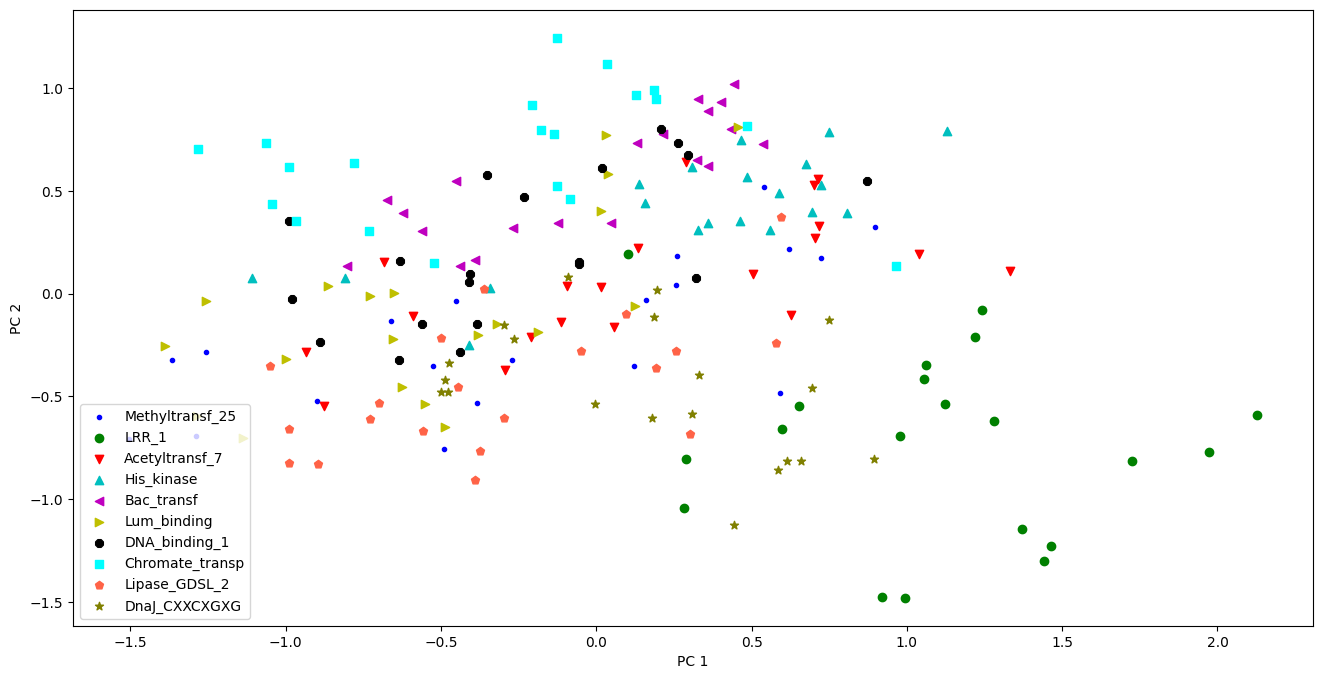

In [65]:
colors = ['b', 'g', 'r', 'c','m', 'y','k', 'aqua', 'tomato', 'olive']
markers = ['.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*']
plt.subplots(figsize=(16, 8))
for l, c, m in zip(np.unique(arrLabels), colors, markers):
    plt.scatter(X_pca[arrLabels==l, 0], X_pca[arrLabels==l, 1], c=c, label=Familias[l], marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()